In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

100%|██████████| 395M/395M [00:03<00:00, 123MB/s]


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch.nn.functional as F

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_size  = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [ ]:
train_tfms = T.Compose([T.Resize(image_size),
                        T.CenterCrop(image_size),
                        T.ToTensor(),
                        T.Normalize(*stats)])

In [ ]:
dir_path = './animefacedataset'
train_ds = ImageFolder(dir_path,transform=train_tfms)
train_dl = DataLoader(train_ds,batch_size,num_workers=3,pin_memory=3)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def denorm(img_tensors):
    return img_tensors*stats[1][0]+stats[0][0]

In [ ]:
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # 3 x64x64
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),
    #64x32x32

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),
    #128x16x16

    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),
    #256x8x8

    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    #512x4x4

    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
    #1x1x1
    nn.Flatten(),
    nn.Sigmoid()
    )

In [ ]:
discriminator.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #  512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #  256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    #  3 x 64 x 64
)

In [ ]:
generator.to(device)

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [ ]:
input = torch.randn(batch_size, latent_size, 1, 1).to(device)
print(input.shape)
fake_images = generator(input).to(device)

print(fake_images.shape)


torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


#training discriminator

In [ ]:
def train_discriminator(real_images,opt_d):
    # clear gradient
    opt_d.zero_grad()

    #passing real images through disc.
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1)
    real_loss = F.binary_cross_entropy(real_preds,real_targets).to(device)
    real_score = torch.mean(real_preds).item()

    #generte fake 
    latent = torch.randn(batch_size,latent_size,1,1).to(device)
    fake_images = generator(latent)

    #passing fake image through disc.
    fake_targets = torch.zeros(fake_images.size(0),1).to(device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds,fake_targets).to(device)
    fake_score = torch.mean(fake_preds).item()

    #updating disc. weights
    loss = real_loss+fake_score
    loss.backward()
    opt_d.step()
    return loss.item(), real_score,fake_score


In [ ]:
def train_generator(opt_g):
    opt_g.zero_grad()

    #generate fake images
    latent = torch.randn(batch_size,latent_size,1,1).to(device)
    fake_images = generator(latent)

    # fooling disc.
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size,1).to(device)
    loss = F.binary_cross_entropy(preds,targets)

    #updating generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
impo

In [ ]:
sample_dir = 'generated_images'
os.makedirs(sample_dir,exist_ok=True)

NameError: ignored

In [ ]:
def save_samples(index,latent_tensors,show=True):
    fake_images = generator(latent_tensors)
    fake_im_name = 'gen_anime_face_{}.png'.format(index)
    save_image(denorm(fake_images),os.path.join(sample_dir,fake_im_name),nrow=8)
    print('Saving =>',fake_im_name)
    if show:
        fig,ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))

In [ ]:
fixed_latent = torch.randn(64,latent_size,1,1).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving => gen_anime_face_0.png


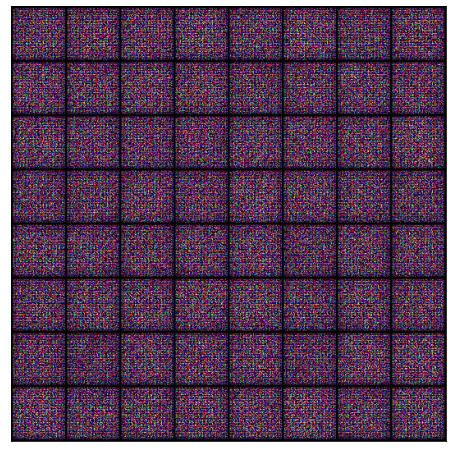

In [ ]:
save_samples(0,fixed_latent)

In [ ]:
def fit(epochs,lr,start_idx=1):
    torch.cuda.empty_cache()

    #loss and score
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    #optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))
    opt_g = torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))

    for epoch in range(epochs):
        for real_images,_ in tqdm(train_dl):
            # train_disc
            loss_d,real_score,fake_score = train_discriminator(real_images,opt_d)
            #train_gen
            loss_g = train_generator(opt_g)

        # recording loss
        losses_g.append(loss_g)
        losses_d.append(loss_d)

        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch:",epoch+1," loss_g:",loss_g," real_score:",real_score," Fake_score:",fake_score)

        #save image
        save_samples(epoch+start_idx,fixed_latent,show=False)

    return losses_g,losses_d,real_scores,fake_scores